In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [3]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [5]:
r

tensor([[0.2812, 0.1846, 0.9330, 0.9244, 0.5690, 0.5585, 0.2038, 0.5500, 0.7288,
         0.9222, 0.2817, 0.5323, 0.8120, 0.7950, 0.7034, 0.0887],
        [0.5080, 0.9661, 0.8358, 0.9866, 0.7491, 0.8700, 0.3538, 0.3502, 0.5449,
         0.1327, 0.0816, 0.7026, 0.1619, 0.1846, 0.2353, 0.0626]],
       device='cuda:0')

In [6]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [7]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

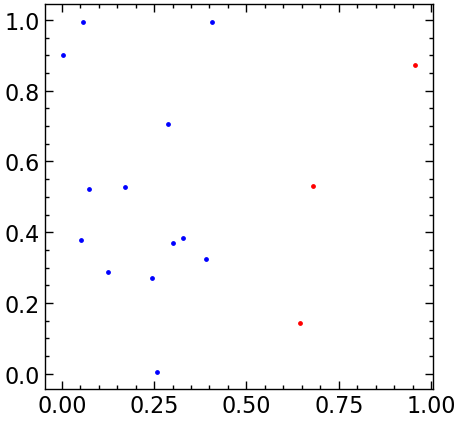

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [9]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [10]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles (**NOTE: THIS HAS BEEN UPDATED SINCE THE YOUTUBE VIDEO AND IS MUCH MORE EFFICIENT. THANK YOU TO @swni ON REDDIT FOR THE SUGGESTION**)

In [11]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.3022, 0.3892],
        [0.3022, 0.1261],
        [0.3022, 0.0530],
        [0.3022, 0.2455],
        [0.3022, 0.9567],
        [0.3022, 0.6449],
        [0.3022, 0.4073],
        [0.3022, 0.0024],
        [0.3022, 0.2885],
        [0.3022, 0.0570],
        [0.3022, 0.0732],
        [0.3022, 0.2583],
        [0.3022, 0.6814],
        [0.3022, 0.1713],
        [0.3022, 0.3291],
        [0.3892, 0.1261],
        [0.3892, 0.0530],
        [0.3892, 0.2455],
        [0.3892, 0.9567],
        [0.3892, 0.6449],
        [0.3892, 0.4073],
        [0.3892, 0.0024],
        [0.3892, 0.2885],
        [0.3892, 0.0570],
        [0.3892, 0.0732],
        [0.3892, 0.2583],
        [0.3892, 0.6814],
        [0.3892, 0.1713],
        [0.3892, 0.3291],
        [0.1261, 0.0530],
        [0.1261, 0.2455],
        [0.1261, 0.9567],
        [0.1261, 0.6449],
        [0.1261, 0.4073],
        [0.1261, 0.0024],
        [0.1261, 0.2885],
        [0.1261, 0.0570],
        [0.1261, 0.0732],
        [0.1

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [12]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.0870, -0.1760, -0.2491, -0.0566,  0.6545,  0.3427,  0.1051, -0.2997,
        -0.0136, -0.2451, -0.2289, -0.0439,  0.3793, -0.1309,  0.0269, -0.2631,
        -0.3362, -0.1436,  0.5675,  0.2557,  0.0181, -0.3868, -0.1007, -0.3321,
        -0.3159, -0.1309,  0.2923, -0.2179, -0.0601, -0.0731,  0.1194,  0.8306,
         0.5188,  0.2812, -0.1237,  0.1624, -0.0691, -0.0529,  0.1322,  0.5553,
         0.0452,  0.2029,  0.1925,  0.9037,  0.5919,  0.3543, -0.0506,  0.2355,
         0.0040,  0.0202,  0.2053,  0.6284,  0.1183,  0.2760,  0.7111,  0.3994,
         0.1617, -0.2431,  0.0430, -0.1885, -0.1723,  0.0127,  0.4359, -0.0743,
         0.0835, -0.3118, -0.5494, -0.9543, -0.6682, -0.8996, -0.8835, -0.6984,
        -0.2752, -0.7854, -0.6276, -0.2376, -0.6425, -0.3564, -0.5879, -0.5717,
        -0.3866,  0.0365, -0.4736, -0.3159, -0.4049, -0.1188, -0.3502, -0.3341,
        -0.1490,  0.2742, -0.2360, -0.0782,  0.2861,  0.0546,  0.0708,  0.2559,
         0.6790,  0.1689,  0.3266, -0.23

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [13]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.0981, 0.1942, 0.2493, 0.1126, 0.8266, 0.4101, 0.6351, 0.6102, 0.3380,
        0.6709, 0.2752, 0.3651, 0.4125, 0.2064, 0.0310, 0.2656, 0.3404, 0.1527,
        0.7905, 0.3127, 0.6719, 0.6946, 0.3962, 0.7477, 0.3729, 0.3430, 0.3585,
        0.2992, 0.0855, 0.1161, 0.1204, 1.0170, 0.5382, 0.7621, 0.6259, 0.4501,
        0.7099, 0.2406, 0.3100, 0.6067, 0.2458, 0.2251, 0.2196, 1.0311, 0.6363,
        0.7124, 0.5257, 0.4050, 0.6163, 0.1458, 0.4238, 0.6470, 0.1921, 0.2761,
        0.9318, 0.4193, 0.7415, 0.6742, 0.4372, 0.7460, 0.3036, 0.2655, 0.5073,
        0.2675, 0.1403, 0.7939, 0.5626, 0.9546, 0.6887, 0.9076, 0.9511, 1.1136,
        0.4395, 0.8579, 0.7959, 0.8841, 0.9928, 0.6663, 1.0333, 0.6853, 0.4102,
        0.3892, 0.6103, 0.3971, 0.4158, 0.3120, 0.3503, 0.5796, 0.9999, 0.5390,
        0.5230, 0.6159, 0.3456, 0.1078, 0.3854, 0.9299, 0.7730, 0.4085, 0.6108,
        0.3685, 0.2839, 0.7009, 0.4304, 0.2133, 0.3249, 0.4721, 1.0073, 0.7769,
        0.4787, 0.6671, 0.5474, 0.6083, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [14]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  1],
        [ 0,  4],
        [ 0, 15],
        [ 1, 15],
        [ 2,  3],
        [ 8, 10],
        [11, 14]], device='cuda:0')

We will call all the particles in the left column "1" and the right column "2"

In [15]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [16]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [17]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [18]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

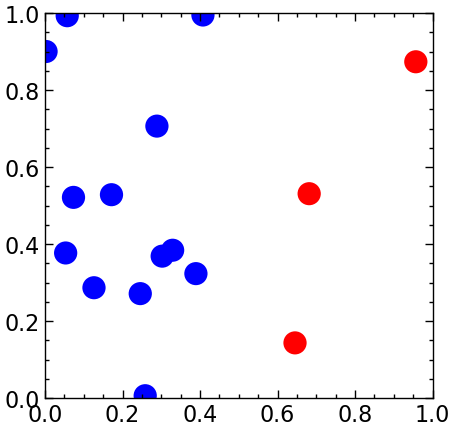

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

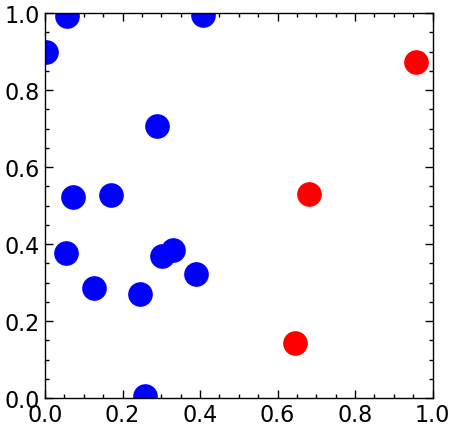

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [ ]:
n_particles = 5000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [ ]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

In [ ]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)